In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from torch.utils.data.dataset import TensorDataset
from tqdm.notebook import tqdm

## Recurrent Neural Network : RNN
### The new concept : varying lengths in the sequence
### In a recurrent network, an internal NN is used multiple times to process the input

In [2]:
# -- creating a simple net that takes 2 numbers as input features and give 1 number as output

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        input_size = 2
        hidden_size = 10
        output_size = 1
        
        self.layer1 = nn.Linear(input_size,hidden_size)
        self.layer2 = nn.Linear(hidden_size,output_size)
        self.activation1 = nn.ReLU()
        
    def forward(self,x):
        
        out = self.layer1(x)
        out = self.activation1(out)
        out = self.layer2(out)
        
        return out

### Let's create a network which will use the above Net as internal network

In [3]:
class BasicRNN(nn.Module):
    def __init__(self):
        super(BasicRNN,self).__init__()
        
        self.internal_net = Net()
        
        
    def forward(self,x):
        
        sequence_length = len(x)
        outputs = []
        
        for i in range(sequence_length):
    
            output_i = self.internal_net(x[i])
            outputs.append(output_i)
        
        return torch.cat(outputs)

In [4]:
#Here its processing input of length 3
x = torch.FloatTensor([[0.8,0.2],[0.42,0.1],[0.9,-0.3]])

basicRNN = BasicRNN()

basicRNN(x)

tensor([0.2216, 0.2882, 0.2308], grad_fn=<CatBackward>)

### In this example each input is processed independently. 
### If we want to create a cross-talk, we need to create an "information-exchange" operation

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        input_size = 2+3
        hidden_size = 10
        output_size1 = 1
        output_size2 = 3
        
        self.layer1 = nn.Linear(input_size,hidden_size)
        self.layer2 = nn.Linear(hidden_size,output_size1)
        self.activation1 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_size,output_size2)
        
        
    def forward(self,x1,x2):

        out = self.layer1(torch.cat([x1,x2],dim=0) )
        out = self.activation1(out)

        
        return self.layer2(out),self.layer3(out)

In [8]:
#nn.RNNCell??

In [9]:
class BasicRNN(nn.Module):
    def __init__(self):
        super(BasicRNN,self).__init__()
        
        self.internal_net = Net()
        
        
    def forward(self,x):
        
        sequence_length = len(x)
        
        outputs = []
        
        hidden_state = torch.zeros(3)
        
        for i in range(sequence_length):
            
            output_i, hidden_state = self.internal_net(x[i],hidden_state)
            outputs.append(output_i)

        return torch.cat(outputs),hidden_state

In [10]:
x = torch.FloatTensor([[0.8,0.2],[0.42,0.1],[0.9,-0.3],[0.2,0.1],[0.8,-0.3]])

basicRNN = BasicRNN()

basicRNN(x)

(tensor([-0.1287, -0.1274, -0.1449, -0.1234, -0.1434], grad_fn=<CatBackward>),
 tensor([ 0.2863, -0.0496,  0.2556], grad_fn=<AddBackward0>))

In [16]:
### PyTorch has inbuilt layers to tackle all the complexities

In [17]:
rnn = nn.LSTM(10, 20, 2)
X  = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(X, (h0, c0))

In [18]:
output.shape, hn.shape, cn.shape

(torch.Size([5, 3, 20]), torch.Size([2, 3, 20]), torch.Size([2, 3, 20]))

### What if we use this LSTM layer as the internal state of the above RNN net?

In [20]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        
        size_of_sequence_element = 2
        hidden_state_size = 5
        self.lstm = nn.LSTM(size_of_sequence_element,hidden_state_size,batch_first=True)
        
        output_size = 3
        self.linear = nn.Linear(hidden_state_size,output_size)
        
    def forward(self,x):
        
        hidden_states, (final_hidden_state, cell_state) = self.lstm(x)
        output = self.linear(final_hidden_state)
        
        return output
    
rnn = RNN()

x = torch.FloatTensor([[[0.8,0.2],[0.42,0.1],[0.9,-0.3],[0.2,0.1],[0.8,-0.3],[0.4,0.3]]])

rnn(x)

tensor([[[ 0.1844,  0.2421, -0.0059]]], grad_fn=<AddBackward0>)

## The treatment of different size elements inside a batch
### What do we do if the input elements have different sizes ??

In [21]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

my_sequences = [
    torch.FloatTensor([[1],[2],[3],[4]]),
    torch.FloatTensor([[5],[6],[7]]),
    torch.FloatTensor([[8],[9],[10],[11],[12],[13]])
]

sequence_lengths = [len(x) for x in my_sequences]
# sequence_lengths = [5, 3, 6]

#zero pad you sequences to the length of the largest sequence
max_length = np.max(sequence_lengths)
n_sequences = len(my_sequences)
sequence_tensor = torch.zeros((n_sequences,max_length,1)).float()
for i, (seq,seq_len) in enumerate( zip(my_sequences,sequence_lengths) ):
    sequence_tensor[i,:seq_len] = seq

In [22]:
sequence_lengths

[4, 3, 6]

In [23]:
sequence_tensor

tensor([[[ 1.],
         [ 2.],
         [ 3.],
         [ 4.],
         [ 0.],
         [ 0.]],

        [[ 5.],
         [ 6.],
         [ 7.],
         [ 0.],
         [ 0.],
         [ 0.]],

        [[ 8.],
         [ 9.],
         [10.],
         [11.],
         [12.],
         [13.]]])

In [24]:
#sort the sequences largest to smallest
sequence_lengths = torch.LongTensor(sequence_lengths)
sequence_lengths, perm_index = sequence_lengths.sort(0, descending=True)
sequence_tensor = sequence_tensor[perm_index]

sequence_tensor

tensor([[[ 8.],
         [ 9.],
         [10.],
         [11.],
         [12.],
         [13.]],

        [[ 1.],
         [ 2.],
         [ 3.],
         [ 4.],
         [ 0.],
         [ 0.]],

        [[ 5.],
         [ 6.],
         [ 7.],
         [ 0.],
         [ 0.],
         [ 0.]]])

In [25]:
# sequence_lengths = tensor([6, 5, 3])
# tensor([[1., 2., 3., 4., 5., 6.],
#        [1., 2., 3., 4., 5., 0.],
#        [1., 2., 3., 0., 0., 0.]])


packed_input = pack_padded_sequence(sequence_tensor,sequence_lengths.data.numpy(),batch_first=True)

In [26]:
packed_input

PackedSequence(data=tensor([[ 8.],
        [ 1.],
        [ 5.],
        [ 9.],
        [ 2.],
        [ 6.],
        [10.],
        [ 3.],
        [ 7.],
        [11.],
        [ 4.],
        [12.],
        [13.]]), batch_sizes=tensor([3, 3, 3, 2, 1, 1]), sorted_indices=None, unsorted_indices=None)

In [27]:
size_of_sequence_element = 1
hidden_state_size = 5
lstm = nn.LSTM(size_of_sequence_element,hidden_state_size,batch_first=True)

hidden_states, (final_hidden_state, cell_state) = lstm(packed_input)

In [28]:
final_hidden_state, final_hidden_state.shape

(tensor([[[ 0.0331,  0.0126, -0.0009, -0.0282, -0.0284],
          [ 0.1988,  0.1588, -0.0421, -0.1013, -0.2009],
          [ 0.1223,  0.0761, -0.0127, -0.0693, -0.1110]]],
        grad_fn=<StackBackward>),
 torch.Size([1, 3, 5]))

In [29]:
cell_state, cell_state.shape

(tensor([[[ 1.7765,  0.0197, -0.3779, -0.9493, -4.9460],
          [ 1.0908,  0.3184, -0.4271, -0.5575, -1.9210],
          [ 1.3804,  0.1384, -0.4388, -0.6687, -2.2375]]],
        grad_fn=<StackBackward>),
 torch.Size([1, 3, 5]))

In [30]:
output, seq_lengths = pad_packed_sequence( hidden_states , batch_first=True)

output, output.shape, seq_lengths

(tensor([[[ 0.0835,  0.0234, -0.0064, -0.0208, -0.0670],
          [ 0.0779,  0.0288, -0.0051, -0.0310, -0.0691],
          [ 0.0650,  0.0263, -0.0033, -0.0347, -0.0572],
          [ 0.0526,  0.0215, -0.0021, -0.0343, -0.0456],
          [ 0.0419,  0.0167, -0.0014, -0.0317, -0.0361],
          [ 0.0331,  0.0126, -0.0009, -0.0282, -0.0284]],
 
         [[ 0.1603,  0.0551, -0.0428, -0.0531, -0.1800],
          [ 0.2122,  0.1155, -0.0579, -0.0771, -0.2344],
          [ 0.2149,  0.1519, -0.0536, -0.0920, -0.2283],
          [ 0.1988,  0.1588, -0.0421, -0.1013, -0.2009],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],
 
         [[ 0.1427,  0.0630, -0.0192, -0.0420, -0.1202],
          [ 0.1408,  0.0818, -0.0179, -0.0620, -0.1299],
          [ 0.1223,  0.0761, -0.0127, -0.0693, -0.1110],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.00

## Let's try to see an example of dampening bouncing ball

In [31]:
df = pd.read_hdf('bouncing_ball.h5')
test_df = pd.read_hdf('bouncing_ball_test.h5')


In [32]:

df.head()

,true trajectory,measured trajectory,seq_length
0,"[[-1.0, -0.3690598028922245], [-0.965210051152...","[[-1.0182375361258558, -0.3537065145216879], [...",58
1,"[[-1.0, -0.17756836443188584], [-0.96276681618...","[[-0.9657440707917792, -0.15494667100717954], ...",54
2,"[[-1.0, -0.6312861713483072], [-0.969426921379...","[[-0.973336857412208, -0.5957531474075483], [-...",66
3,"[[-1.0, -0.8214449635574403], [-0.963573197491...","[[-0.9908170135595872, -0.8109444836208404], [...",55
4,"[[-1.0, -0.39406307723756784], [-0.97882092848...","[[-0.989381957387418, -0.3753250439943422], [-...",80


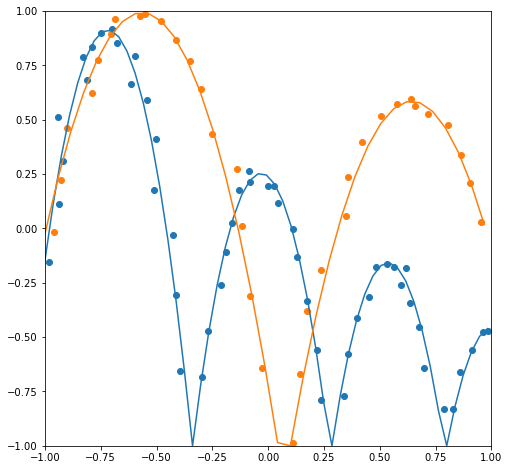

In [33]:
fig, ax = plt.subplots(figsize=(8,8))

for _ in range(2):
    idx = np.random.randint(len(df))

    ax.plot(df.loc[idx]['true trajectory'][:,0],df.loc[idx]['true trajectory'][:,1])
    ax.scatter(df.loc[idx]['measured trajectory'][:,0],df.loc[idx]['measured trajectory'][:,1])

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
plt.show()

### Building the custom dataset

In [34]:
from torch.utils.data import Dataset, DataLoader

class MyCustomDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, dataframe):
        
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        sample_df = self.df.iloc[idx]
        sample = {
            'seq_length': sample_df['seq_length'],
            'true trajectory': sample_df['true trajectory'],
            'measured trajectory': sample_df['measured trajectory']
        }
        return sample

my_dataset = MyCustomDataset(df)

### In the case of varying element size, where our input data does not "stack" well, we need to create a custom "batch building" function
#### this function gets a list of items from the dataset object, and we must give back nice rectengular tensors containing the relevant parts. stick to a X,y format in the output. in this case we need to pass to the neural net both the input sequence and the sequence lengths, so X is actually a tuple containing both objects

In [35]:
def create_batch(batch):
    
    lengths = [sample['seq_length'] for sample in batch]
    
    
    targets = [ torch.FloatTensor(sample['true trajectory']) for sample in batch]
    measured = [ torch.FloatTensor(sample['measured trajectory']) for sample in batch]
    
    max_length = np.max(lengths)
    n_sequences = len(measured)
    
    targets_tensor = torch.zeros((n_sequences,max_length,2)).float()
    measured_tensor = torch.zeros((n_sequences,max_length,2)).float()
    
    for i in range(n_sequences):
        seq_len = lengths[i]
        
        targets_tensor[i,:seq_len] = targets[i]
        measured_tensor[i,:seq_len] = measured[i]
    
    sequence_lengths = torch.LongTensor(lengths)
    sequence_lengths, perm_index = sequence_lengths.sort(0, descending=True)
    targets_tensor = targets_tensor[perm_index]
    measured_tensor = measured_tensor[perm_index]
                            
    return measured_tensor, sequence_lengths, targets_tensor

### Create a dataloader using this batch function 

In [36]:
dataset_loader = torch.utils.data.DataLoader(my_dataset,
                                             batch_size=3, shuffle=True,collate_fn=create_batch)

In [37]:
for x,lengths,targets in dataset_loader:
    print(x.shape,lengths.shape,targets.shape)
    print('-------')
    break


torch.Size([3, 42, 2]) torch.Size([3]) torch.Size([3, 42, 2])
-------


### Now that we know how to batch variable size input (and output) let's build an RNN to predict the true trajectory from the measured trajectory

In [38]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        
        size_of_sequence_element = 2
        hidden_state_size = 10
        self.lstm = nn.LSTM(size_of_sequence_element,hidden_state_size,batch_first=True,
                            bidirectional=True,num_layers=2)
        
        output_size = 2
        self.linear = nn.Linear(2*hidden_state_size,output_size)
        
        
    def forward(self,x,sequence_lengths):

        packed_input = pack_padded_sequence(x,sequence_lengths.data.numpy(),batch_first=True)
        
        hidden_states, (final_hidden_state, cell_state) = self.lstm(packed_input)
        
        output,lengths = pad_packed_sequence( hidden_states , batch_first=True)
        
        output = self.linear(output)
        
        for sample_i in range(len(lengths)):
            seq_length = lengths[sample_i]
            output[sample_i][seq_length:,:] = 0
        
        
        return output

In [39]:
### -- training loop --- ###
rnn = RNN()
dataset_loader = torch.utils.data.DataLoader(my_dataset,
                                             batch_size=10, shuffle=True,collate_fn=create_batch)
loss_func = nn.MSELoss()
optimiser = torch.optim.Adam(rnn.parameters(),lr=0.001)
rnn.train()

batch_i = -1
for x,lengths,y in tqdm( dataset_loader ):
    batch_i+=1

    optimiser.zero_grad()

    outputs = rnn(x,lengths)
    loss = loss_func(outputs,y)
    loss.backward()
    optimiser.step()

In [40]:
%%capture
from matplotlib import animation,rc
from IPython.display import HTML

index_to_test = 48 # select an index from the test dataset

test_dataset = MyCustomDataset(test_df[index_to_test:index_to_test+1])

test_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=1, shuffle=False,collate_fn=create_batch)


# switch the RNN to eval mode (to disable dropout)
rnn.eval()

itr = iter(test_loader)
x,lengths,y = itr.next()

predicted = rnn(x,lengths)
predicted = predicted[0].data.numpy()


traj, measured,_ = test_df.loc[index_to_test]

fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)


line, = ax.plot([],[],lw=2,label='target')
scat = ax.scatter([],[],label='measured')
pred_line = ax.plot(predicted[:,0],predicted[:,1],label='predicted')
ax.legend()

def init():
    line.set_data([],[])
    scat.set_offsets(np.zeros((1,2)))
    return (line,scat,)

def animate(i):
    x = traj[:,0][:i]
    y = traj[:,1][:i]
    line.set_data(x,y)
    scat.set_offsets(measured[:i])
    
    return ( line,)

anim = animation.FuncAnimation(fig,animate,init_func=init,frames=80,interval=30,blit=True)

In [41]:
HTML(anim.to_jshtml())

## Predicting a future trajectory based on measured past

In [42]:
chunk_df = pd.read_hdf('bouncing_ball_chunks.h5')
chunk_test_df = pd.read_hdf('bouncing_ball_chunks_test.h5')

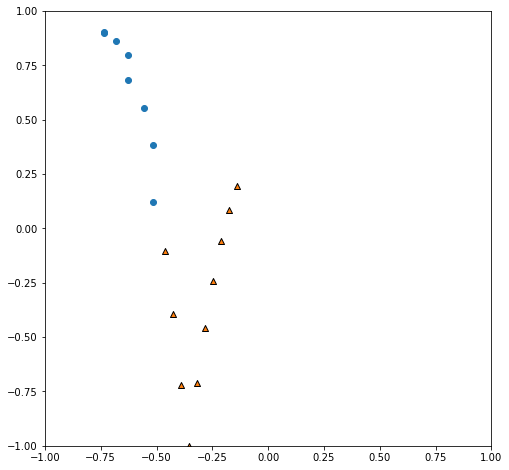

In [43]:
fig, ax = plt.subplots(figsize=(8,8))


idx = np.random.randint(len(chunk_df))

ax.scatter(chunk_df.loc[idx]['input_arr'][:,0],chunk_df.loc[idx]['input_arr'][:,1])
ax.scatter(chunk_df.loc[idx]['target_arr'][:,0],chunk_df.loc[idx]['target_arr'][:,1],ec='k',marker='^')

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
plt.show()

In [45]:
class ChunksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, dataframe):
        
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        sample_df = self.df.iloc[idx]
        sample = {
            'seq_length': sample_df['seq_length'],
            'input_arr': sample_df['input_arr'],
            'target_arr': sample_df['target_arr']
        }
        return sample

c_dataset = ChunksDataset(chunk_df)

In [46]:
def create_batch(batch):
    
    lengths = [sample['seq_length'] for sample in batch]
    
    
    targets = [ torch.FloatTensor(sample['target_arr']) for sample in batch]
    measured = [ torch.FloatTensor(sample['input_arr']) for sample in batch]
    
    output_length = len(targets[0])
    
    max_length = np.max(lengths)
    n_sequences = len(measured)
    
    targets_tensor = torch.zeros((n_sequences,output_length,2)).float()
    measured_tensor = torch.zeros((n_sequences,max_length,2)).float()
    
    for i in range(n_sequences):
        seq_len = lengths[i]
        
        targets_tensor[i,:output_length] = targets[i]
        measured_tensor[i,:seq_len] = measured[i]
    
    sequence_lengths = torch.LongTensor(lengths)
    sequence_lengths, perm_index = sequence_lengths.sort(0, descending=True)
    targets_tensor = targets_tensor[perm_index]
    measured_tensor = measured_tensor[perm_index]
    
    return measured_tensor,sequence_lengths, targets_tensor

In [47]:
dataset_loader = torch.utils.data.DataLoader(c_dataset,
                                             batch_size=15, shuffle=True,collate_fn=create_batch)


for x,legths,y in dataset_loader:
    print(x.shape,legths.shape,y.shape)
    print('-------')
    break


torch.Size([15, 9, 2]) torch.Size([15]) torch.Size([15, 10, 2])
-------


In [48]:
class SequenceRNN(nn.Module):
    def __init__(self):
        super(SequenceRNN,self).__init__()
        
        size_of_sequence_element = 2
        self.hidden_state_size = 15
        self.num_layers = 2
        
        self.encoder_lstm = nn.LSTM(size_of_sequence_element,self.hidden_state_size,
                                    batch_first=True,num_layers=self.num_layers,dropout=0.2)
        
        self.decoder_lstm = nn.LSTM(self.hidden_state_size,self.hidden_state_size,batch_first=True)
        
        output_size = 2
        self.linear = nn.Linear(self.hidden_state_size,output_size)
        
        
    def forward(self,x,sequence_lengths,outputsize = 10):
        
        batch_s = len(sequence_lengths)
        
        packed_input = pack_padded_sequence(x,sequence_lengths.data.numpy(),batch_first=True)
        hidden_states, (final_hidden_state, cell_state) = self.encoder_lstm(packed_input)
    
        final_hidden_state = final_hidden_state[1]
     
        final_hidden_state = final_hidden_state.view(batch_s,1,self.hidden_state_size)

        
        _, (output_hidden_states,_) = self.decoder_lstm(final_hidden_state)
        
        
        
        decoder_sequence = output_hidden_states.permute(1,0,2)
        
        
        for output_i in range(outputsize-1):
            _, (output_hidden_states,_) = self.decoder_lstm(decoder_sequence)
            decoder_sequence = torch.cat([decoder_sequence,output_hidden_states.permute(1,0,2)],dim=1)

            #print(decoder_sequence.shape)
            
        output = self.linear(decoder_sequence)

        return output


In [49]:
s_rnn = SequenceRNN()

s_rnn(x,legths).shape

torch.Size([15, 10, 2])

In [50]:
from IPython.display import clear_output


s_rnn = SequenceRNN()
dataset_loader = torch.utils.data.DataLoader(c_dataset,
                                             batch_size=10, shuffle=True,collate_fn=create_batch)
loss_func = nn.MSELoss()

In [51]:
optimiser = torch.optim.Adam(s_rnn.parameters(),lr=0.001)
s_rnn.train()

batch_i = -1

for epoch in range(10):
    clear_output()
    for x,lengths,y in tqdm( dataset_loader ):
        batch_i+=1

        optimiser.zero_grad()

        outputs = s_rnn(x,lengths)
        loss = loss_func(outputs,y)
        loss.backward()
        optimiser.step()


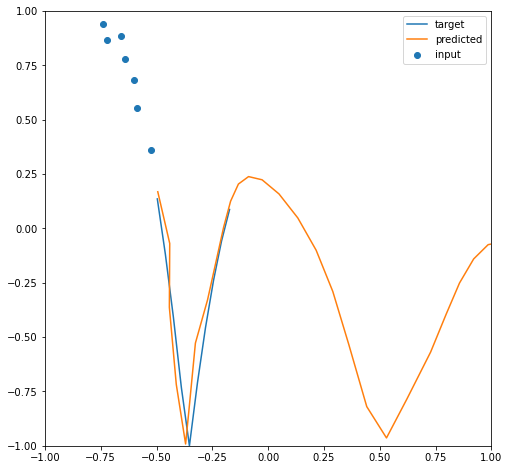

In [52]:
index_to_test = np.random.randint(len(chunk_test_df))

s_rnn.eval()

c_dataset_test = ChunksDataset(chunk_test_df[index_to_test:index_to_test+1])
dataset_loader = torch.utils.data.DataLoader(c_dataset_test,
                                             batch_size=1, shuffle=False,collate_fn=create_batch)

itr = iter(dataset_loader)
x,lengths,y = itr.next()

predicted = s_rnn(x,lengths,30)
predicted = predicted[0].data.numpy()


fig, ax = plt.subplots(figsize=(8,8))


ax.scatter(chunk_test_df.loc[index_to_test]['input_arr'][:,0],chunk_test_df.loc[index_to_test]['input_arr'][:,1],label='input')
ax.plot(chunk_test_df.loc[index_to_test]['target_arr'][:,0],chunk_test_df.loc[index_to_test]['target_arr'][:,1],label='target')
ax.plot(predicted[:,0],predicted[:,1],label='predicted')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.legend()
plt.show()